In [1]:
import imutils
import numpy as np
import cv2
from PIL import Image
from IPython.display import display, Javascript
import time


# Face Segmentation

In [2]:
#!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt#
#!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

In [3]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


In [39]:
cap = cv2.VideoCapture(0)
time1 = time.time()
images_list = []

while True:
    success, img = cap.read()
    (h, w) = img.shape[:2]
    
        
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence threshold
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # draw the bounding box of the face along with the associated probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            img = img[startY:endY,startX:endX]
            if time.time() - time1 > 1:
                time1 = time.time()
                images_list.append(img)
            cv2.rectangle(img, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(img, text, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
            
    cv2.imshow('frame', img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
print(len(images_list))

5


# Face Recognition

In [6]:
#from deepface import DeepFace


In [7]:
#DeepFace.stream(db_path="db")

## Face Recognition

[Tutorial](https://github.com/serengil/tensorflow-101/blob/master/python/vgg-face.ipynb)

In [9]:
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.utils import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [11]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [12]:
from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

In [28]:
def preprocess_image(image):
    if image.shape[0] != 224:
        img = Image.fromarray(image)
        img = img.resize((224,224))        
        img = img_to_array(img)
        
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [35]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [33]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)


In [37]:
epsilon = 0.40

def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image((img1)))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image((img2)))[0,:]
    print(type)
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
    
    print("Cosine similarity: ",cosine_similarity)
    print("Euclidean distance: ",euclidean_distance)
    
    if(cosine_similarity < epsilon):
        print("verified... they are same person")
    else:
        print("unverified! they are not same person!")
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(img1)
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(img2)
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    print("-----------------------------------------")

In [41]:
print(type(vgg_face_descriptor.predict(preprocess_image((images_list[0])))))

1/1 [==============================] - 0s 243ms/step
<class 'numpy.ndarray'>


1/1 [==============================] - 0s 245ms/step
Cosine similarity:  -1.1920928955078125e-07
Euclidean distance:  0.0
verified... they are same person


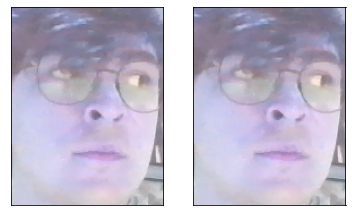

-----------------------------------------
1/1 [==============================] - 0s 235ms/step
Cosine similarity:  0.06019914150238037
Euclidean distance:  44.08192
verified... they are same person


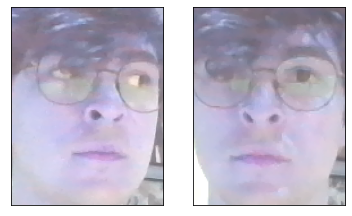

-----------------------------------------
1/1 [==============================] - 0s 271ms/step
Cosine similarity:  0.07590502500534058
Euclidean distance:  46.97801
verified... they are same person


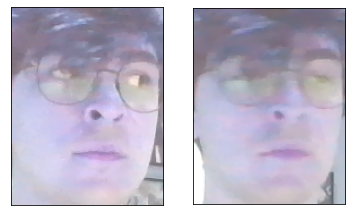

-----------------------------------------
1/1 [==============================] - 0s 276ms/step
Cosine similarity:  0.29787570238113403
Euclidean distance:  85.53223
verified... they are same person


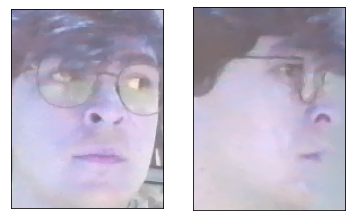

-----------------------------------------
1/1 [==============================] - 0s 277ms/step
Cosine similarity:  0.25869953632354736
Euclidean distance:  81.540985
verified... they are same person


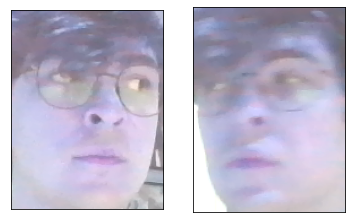

-----------------------------------------
1/1 [==============================] - 0s 277ms/step
Cosine similarity:  0.06019914150238037
Euclidean distance:  44.08192
verified... they are same person


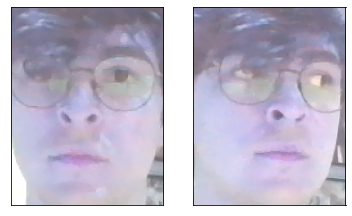

-----------------------------------------
1/1 [==============================] - 0s 232ms/step
Cosine similarity:  0.0
Euclidean distance:  0.0
verified... they are same person


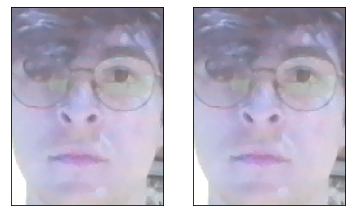

-----------------------------------------
1/1 [==============================] - 0s 248ms/step
Cosine similarity:  0.10163497924804688
Euclidean distance:  58.594795
verified... they are same person


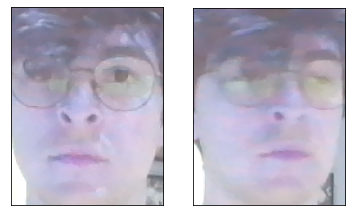

-----------------------------------------
1/1 [==============================] - 0s 276ms/step
Cosine similarity:  0.33236855268478394
Euclidean distance:  96.114525
verified... they are same person


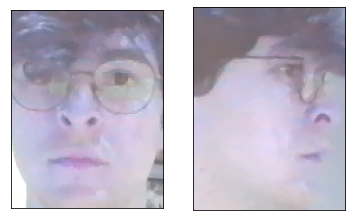

-----------------------------------------
1/1 [==============================] - 0s 275ms/step
Cosine similarity:  0.25615715980529785
Euclidean distance:  86.36755
verified... they are same person


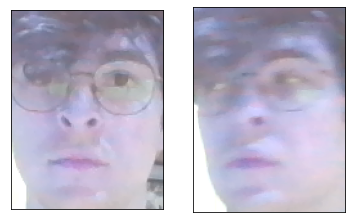

-----------------------------------------
1/1 [==============================] - 0s 256ms/step
Cosine similarity:  0.07590502500534058
Euclidean distance:  46.97801
verified... they are same person


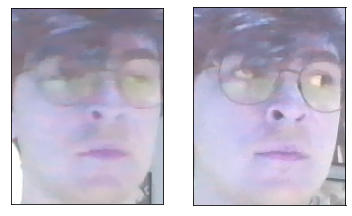

-----------------------------------------
1/1 [==============================] - 0s 281ms/step
Cosine similarity:  0.10163497924804688
Euclidean distance:  58.594795
verified... they are same person


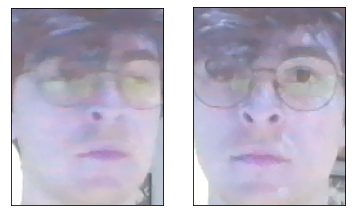

-----------------------------------------
1/1 [==============================] - 0s 255ms/step
Cosine similarity:  0.0
Euclidean distance:  0.0
verified... they are same person


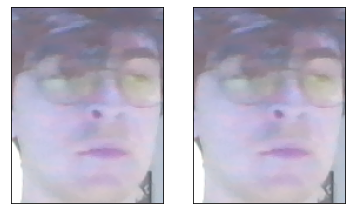

-----------------------------------------
1/1 [==============================] - 0s 252ms/step
Cosine similarity:  0.2781299948692322
Euclidean distance:  70.34103
verified... they are same person


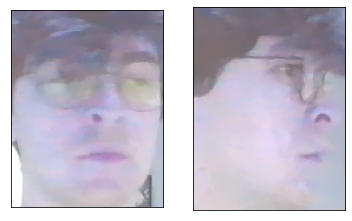

-----------------------------------------
1/1 [==============================] - 0s 270ms/step
Cosine similarity:  0.19085514545440674
Euclidean distance:  62.50765
verified... they are same person


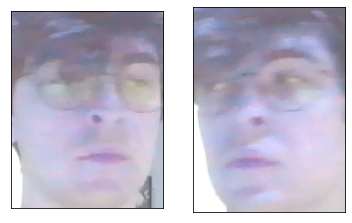

-----------------------------------------
1/1 [==============================] - 0s 277ms/step
Cosine similarity:  0.29787570238113403
Euclidean distance:  85.53223
verified... they are same person


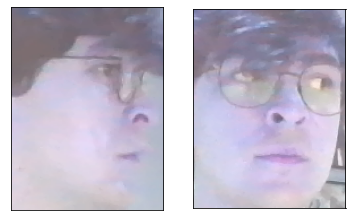

-----------------------------------------
1/1 [==============================] - 0s 273ms/step
Cosine similarity:  0.33236855268478394
Euclidean distance:  96.114525
verified... they are same person


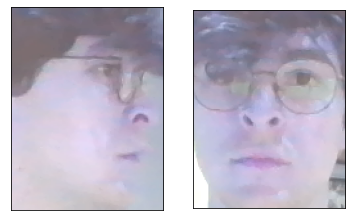

-----------------------------------------
1/1 [==============================] - 0s 254ms/step
Cosine similarity:  0.2781299948692322
Euclidean distance:  70.34103
verified... they are same person


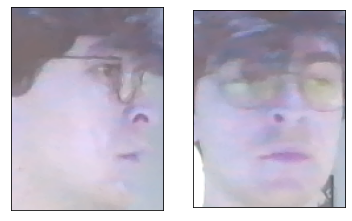

-----------------------------------------
1/1 [==============================] - 0s 270ms/step
Cosine similarity:  0.0
Euclidean distance:  0.0
verified... they are same person


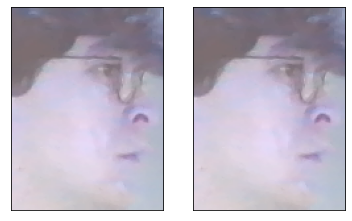

-----------------------------------------
1/1 [==============================] - 0s 258ms/step
Cosine similarity:  0.1790749430656433
Euclidean distance:  57.976173
verified... they are same person


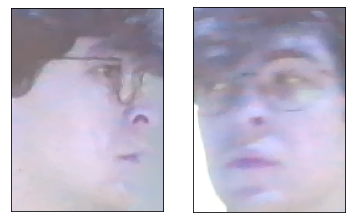

-----------------------------------------
1/1 [==============================] - 0s 276ms/step
Cosine similarity:  0.25869953632354736
Euclidean distance:  81.540985
verified... they are same person


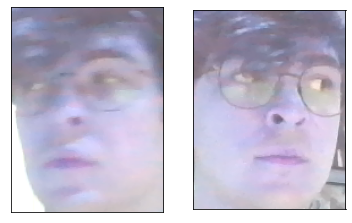

-----------------------------------------
1/1 [==============================] - 0s 254ms/step
Cosine similarity:  0.25615715980529785
Euclidean distance:  86.36755
verified... they are same person


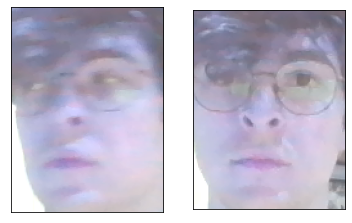

-----------------------------------------
1/1 [==============================] - 0s 278ms/step
Cosine similarity:  0.19085514545440674
Euclidean distance:  62.50765
verified... they are same person


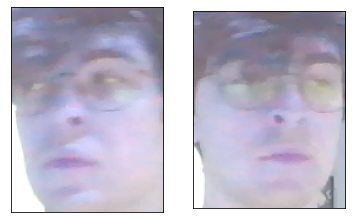

-----------------------------------------
1/1 [==============================] - 0s 262ms/step
Cosine similarity:  0.1790749430656433
Euclidean distance:  57.976173
verified... they are same person


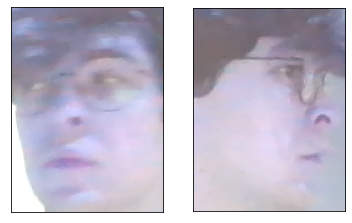

-----------------------------------------
1/1 [==============================] - 0s 256ms/step
Cosine similarity:  1.1920928955078125e-07
Euclidean distance:  0.0
verified... they are same person


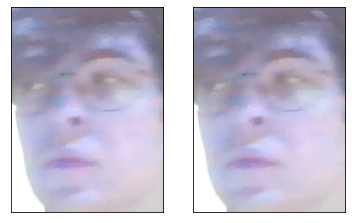

-----------------------------------------


In [40]:
for face in images_list:
    for face2 in images_list:
        verifyFace(face, face2)